In [14]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [15]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [16]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [17]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Data/hawaii.sqlite")
#connect spector function to engine
insp = inspect(engine)

In [18]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [19]:
# View all of the classes that automap found
#used inspect fuction to inspect tables
print(insp.get_table_names())

['measurement', 'station']


In [20]:
# Save references to each table
#create measrement table
measurement = Base.classes.measurement
#create station table
station = Base.classes.station

In [21]:
# Create our session (link) from Python to the DB
sesh = Session(engine)

# Exploratory Precipitation Analysis

In [22]:
# Find the most recent date in the data set.
#inspect columns to get column names
columns = insp.get_columns('measurement')
for column in columns:
    print(column['name'],column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [23]:
#saving most recent recording to a variable using SQL max function and engine execute
most_recent = engine.execute('SELECT max(date) FROM measurement').fetchall()
#Unpacking the value using list comprehesion 
most_recent = most_recent[0][0]
#print statement showing when the most recent date was taken
print(f'the most recent date taken in the database was taken on {most_recent}')

the most recent date taken in the database was taken on 2017-08-23


one year from the last taken date: 2017-08-23 would be: 2016-08-23


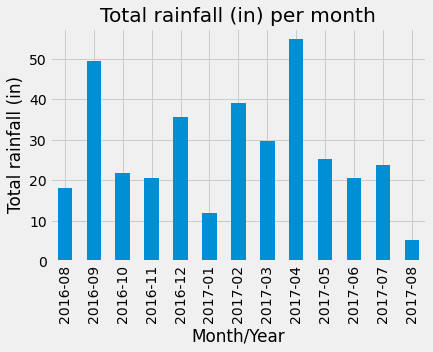

In [24]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

#import datetime function as dt
import datetime as dt
start_date = dt.datetime(2016, 8, 23)

# Calculate the date one year from the last date in data set.
#I just simply picked the same date exactly one year prior to last recorded date
print(f'one year from the last taken date: {most_recent} would be: 2016-08-23')

# Performing a query to get the date and precipitation from the measurements table
#storing the data in a variable called results
results = sesh.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= start_date).all()

#looping thtough my resutls query and sorting them in my prcp tuple
prcp = [{'date': result[0], 'precipitation': result[1]} for result in results]


#Created a dataframe out of my tuple
precip_df = pd.DataFrame(prcp)
#Dropped the NaNs because theyre useless in this case 
precip_df = precip_df.dropna()

#Plotting by date seemed to complex so I thought plotting by month and year is better
#So I created a new colum to drop the dates frome date column and return just month year
# This made grouping easier and plotting easier to interprate
precip_df['date'] = pd.to_datetime(precip_df['date'])
precip_df['month/year'] = precip_df['date'].apply(lambda x: x.strftime('%Y-%m'))

#Plotted data by grouping month/year and adding all the precipitations for that month
precip_df.groupby('month/year')['precipitation'].sum().plot.bar()
plt.xlabel('Month/Year')
plt.ylabel('Total rainfall (in)')
plt.title('Total rainfall (in) per month');



In [25]:
# Use Pandas to calcualte the summary statistics for the precipitation data
#For a more exact describe I grouped everything by month and then described the precip
#this gave us the monthly average, Standard Dev, and Max for each month
precip_df.groupby('month/year')['precipitation'].describe()

,count,mean,std,min,25%,50%,75%,max
month/year,,,,,,,,
2016-08,47.0,0.385106,0.708050,0.0,0.005,0.08,0.2250,2.46
2016-09,173.0,0.285549,0.662214,0.0,0.010,0.07,0.2700,6.70
2016-10,179.0,0.121620,0.344809,0.0,0.000,0.01,0.0800,3.46
2016-11,171.0,0.120234,0.342695,0.0,0.000,0.02,0.0900,2.87
2016-12,178.0,0.199494,0.342967,0.0,0.020,0.06,0.2475,2.37
2017-01,170.0,0.070294,0.276047,0.0,0.000,0.00,0.0175,2.64
2017-02,162.0,0.241111,0.672922,0.0,0.000,0.00,0.0600,5.04
2017-03,169.0,0.175266,0.431165,0.0,0.000,0.00,0.0800,2.40
2017-04,171.0,0.321111,0.702469,0.0,0.000,0.02,0.3100,6.25


# Exploratory Station Analysis

In [26]:
#For loop to return the column names of the station Table 
columns = insp.get_columns('station')
for column in columns:
    print(column['name'],column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [27]:
#Query to return the count of station column
stations = engine.execute('SELECT count(station) FROM station').fetchall()[0][0]
print(f'There are a total of: {stations} stations')

There are a total of: 9 stations


In [28]:
#Queried to return station name from the measurement table
#and the count that each station appears in the table
station_count = sesh.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.station).\
order_by(func.count(measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
#Quried to get the max, min, and average temps  for the station with the most recordings
calcs = sesh.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
filter(measurement.station == station_count[0][0]).all()
lowest = calcs[0][0]
highest = calcs[0][1]
average = round(calcs[0][2],2)

In [31]:
#Print Statments to nicely display the data collected
print(f'At station {station_count[0][0]}:')
print(f'The lowest recorded temp is {lowest}')
print(f'The highest recorded temp is {highest}')
print(f'The average of all recorded temps is {average}')

At station USC00519281:
The lowest recorded temp is 54.0
The highest recorded temp is 85.0
The average of all recorded temps is 71.66


In [32]:
#Selected date exactlyy 12 months frior to last recorded date
start_date = dt.datetime(2016,8,18)

#queried to include, station ID, Date and Temps
#filtered data by most active stations and start dates
temps = sesh.query(measurement.station, measurement.date, measurement.tobs).\
filter(measurement.station == station_count[0][0], measurement.date >= start_date).all()
#store my data in a tuple via a for loop
temps_list = [{'station':temp[0], 'date':temp[1], 'temp':temp[2]} for temp in temps]
#Make Tuple into DF
temps_df = pd.DataFrame(temps_list)
temps_df

,station,date,temp
0,USC00519281,2016-08-19,79.0
1,USC00519281,2016-08-20,81.0
2,USC00519281,2016-08-21,79.0
3,USC00519281,2016-08-22,78.0
4,USC00519281,2016-08-23,77.0
...,...,...,...
351,USC00519281,2017-08-14,77.0
352,USC00519281,2017-08-15,77.0
353,USC00519281,2017-08-16,76.0
354,USC00519281,2017-08-17,76.0


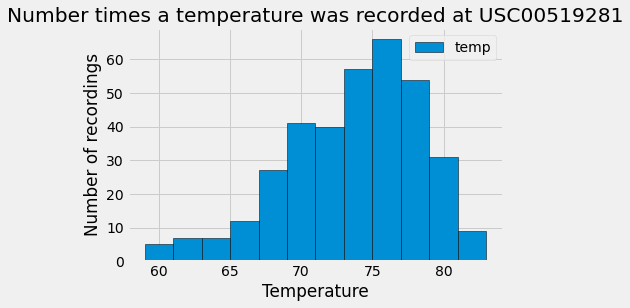

In [33]:
#bautiful Histagram
temps_df.plot.hist(bins =12, ec ='black')
plt.xlabel('Temperature')
plt.ylabel('Number of recordings')
plt.title('Number times a temperature was recorded at USC00519281');


# Close session

In [31]:
# Close Session
sesh.close()